In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import os
from flash.image import ImageClassificationData, ImageClassifier
from flash import Trainer

In [39]:
LOGDIR = 'logs'
NORMALIZED_DATA = '../../Training-baseline/'
EPOCHS = 20
FINETUNE_STRATEGY = 'no_freeze'
VERSION = (str(EPOCHS) + 'Epoch-' + FINETUNE_STRATEGY)

In [40]:
current_run = 'naive-normalization/20Epoch-no_freeze'
metrics = pd.read_csv(f'{LOGDIR}/{current_run}/metrics.csv')
display(metrics)
del metrics["epoch"]
metrics.set_index("step", inplace=True)

,train_accuracy_step,train_f1score_step,train_labelsmoothingcrossentropy_step,epoch,step,val_accuracy,val_f1score,val_labelsmoothingcrossentropy,train_accuracy_epoch,train_f1score_epoch,train_labelsmoothingcrossentropy_epoch
0,0.562500,0.436614,1.523526,0,49,NaN,NaN,NaN,NaN,NaN,NaN
1,0.625000,0.561098,1.339213,0,99,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0,140,0.723179,0.630927,1.037922,NaN,NaN,NaN
3,NaN,NaN,NaN,0,140,NaN,NaN,NaN,0.572363,0.476657,1.497530
4,0.765625,0.616073,0.806584,1,149,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
91,1.000000,1.000000,0.157830,19,2699,NaN,NaN,NaN,NaN,NaN,NaN
92,0.984375,0.983710,0.175484,19,2749,NaN,NaN,NaN,NaN,NaN,NaN
93,0.984375,0.986928,0.181186,19,2799,NaN,NaN,NaN,NaN,NaN,NaN
94,NaN,NaN,NaN,19,2819,0.837086,0.815829,0.709330,NaN,NaN,NaN


<AxesSubplot:title={'center':'F1'}, xlabel='step'>

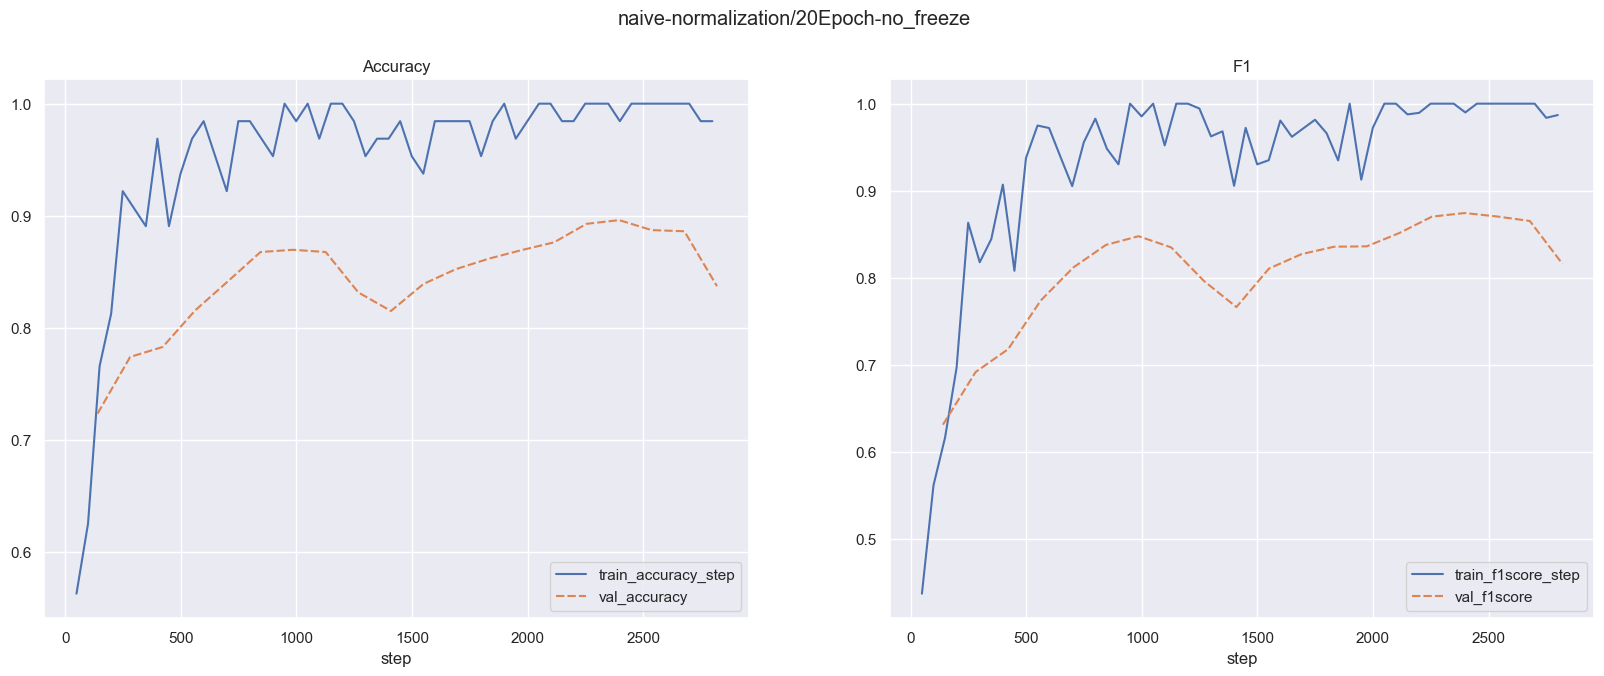

In [41]:
sns.set()

figure, axes = plt.subplots(1, 2, sharex='all', figsize=(20,7))
figure.suptitle(current_run)
axes[0].set_title('Accuracy')
axes[1].set_title('F1')

sns.lineplot(data=metrics[['train_accuracy_step', 'val_accuracy']], ax=axes[0])
sns.lineplot(data=metrics[['train_f1score_step', 'val_f1score']], ax=axes[1])

In [42]:
metadata = pd.read_csv('metadata/pokemon.csv')
pokemon_names = [x for x in os.listdir(NORMALIZED_DATA)]
filtered_metadata = metadata[metadata.name.isin(pokemon_names)]
filtered_metadata = filtered_metadata.loc[:,['name', 'type1']]

In [43]:
le = LabelEncoder()
labels = le.fit_transform(filtered_metadata['type1'])
filtered_metadata['encoded_label'] = labels

type_list = filtered_metadata['type1'].unique()
enc_type_list = filtered_metadata['encoded_label'].unique()

type_lookup = pd.DataFrame(list(zip(type_list, enc_type_list)), columns=['Type_name', 'encoded_type'])

In [44]:
print(type_lookup)

   Type_name  encoded_type
0      grass             9
1       fire             6
2      water            17
3        bug             0
4     normal            12
5     poison            13
6   electric             3
7     ground            10
8      fairy             4
9   fighting             5
10   psychic            14
11      rock            15
12     ghost             8
13       ice            11
14    dragon             2
15      dark             1
16     steel            16
17    flying             7


In [50]:
model = ImageClassifier.load_from_checkpoint("saved-models/" + VERSION + ".pt")
trainer = Trainer(gpus=1)

pred_data = ImageClassificationData.from_files(
    predict_files=[
        '../../Training-baseline/Beautifly/ovcxaplevhokwnke.npy',
    ],
    batch_size = 1
)

pred_data2 = ImageClassificationData.from_files(
    predict_files=[
        '../../Training-baseline/Beautifly/sectpoqinhlieysk.npy',
        '../../Training-baseline/Archeops/iblfgtvmxrttjsjz.npy'
    ],
    batch_size = 1
)

predictions1 = trainer.predict(model, datamodule=pred_data, output='labels')
predictions2 = trainer.predict(model, datamodule=pred_data2, output='labels')

print(predictions1)
print(predictions2)

print(f"""
- Pokemon had the predicted type:
{type_lookup.loc[type_lookup['encoded_type'] == predictions1[0][0]]}
---------------------------------------------------------------------
- The Pokemon in Question actually has the type:
{filtered_metadata[filtered_metadata['name'] == 'Beautifly']}
""")

Using 'efficientnet_b0' provided by rwightman/pytorch-image-models (https://github.com/rwightman/pytorch-image-models).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\CYBORGX\anaconda3\envs\birdclef\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

[[9]]
[[9], [9]]

- Pokemon had the predicted type:
  Type_name  encoded_type
0     grass             9
---------------------------------------------------------------------
- The Pokemon in Question actually has the type:
          name type1  encoded_label
266  Beautifly   bug              0

